# Базовая модель

Как было отмечено ранее, базовые модели включают в себя построение классических методов машинного обучения по квартилям цветов в изображениях: логистическую регрессию, `xgboost`, $K$ ближайших соседей. 

Импортируем инструменты

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import LinearSVC, SVC

Импортируем данные

In [2]:
images_quartiles = pd.read_parquet("images_quartiles.parquet")
images_quartiles.info()
images_quartiles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55322 entries, 0 to 55321
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   red_upper_quartiles    55322 non-null  float64
 1   red_median             55322 non-null  float64
 2   red_lower_quartiles    55322 non-null  float64
 3   green_upper_quartiles  55322 non-null  float64
 4   green_median           55322 non-null  float64
 5   green_lower_quartiles  55322 non-null  float64
 6   blue_upper_quartiles   55322 non-null  float64
 7   blue_median            55322 non-null  float64
 8   blue_lower_quartiles   55322 non-null  float64
 9   target                 55322 non-null  float64
dtypes: float64(10)
memory usage: 4.2 MB


,red_upper_quartiles,red_median,red_lower_quartiles,green_upper_quartiles,green_median,green_lower_quartiles,blue_upper_quartiles,blue_median,blue_lower_quartiles,target
0,0.195892,0.166290,0.152954,0.379395,0.333496,0.317017,0.617920,0.583008,0.556274,1.0
1,0.741699,0.657227,0.434692,0.803223,0.729492,0.527344,0.847290,0.774902,0.595215,1.0
2,0.686035,0.567139,0.567749,0.832275,0.811523,0.804443,0.890137,0.874512,0.867798,1.0
3,0.466248,0.420166,0.320251,0.561768,0.504395,0.410400,0.640625,0.565063,0.477539,1.0
4,0.654297,0.659912,0.615234,0.757324,0.750000,0.696289,0.810547,0.802734,0.752930,1.0


Смотрим на количество объектов каждого класса в выборке

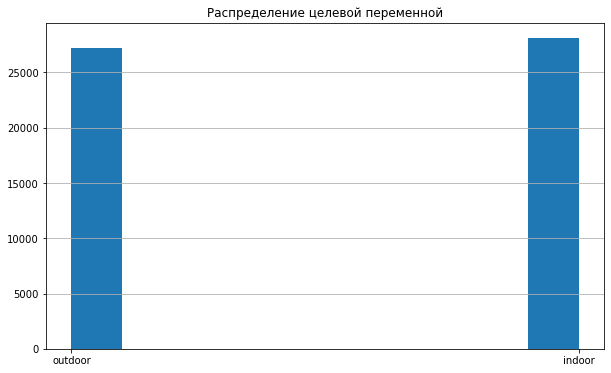

In [3]:
images_quartiles["target"].hist(figsize=(10, 6))
plt.xticks([0, 1], labels=["outdoor", "indoor"])
plt.grid(axis="x")
plt.title("Распределение целевой переменной")
plt.show()

Количество строк каждого класса примерно одинаковое, можно считать выборку сбалансированной. Составляем матрицу объекты-признаки и вектор целевой переменный 

In [4]:
X = images_quartiles.drop(columns=["target"]).values
y = images_quartiles["target"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Проверим распределение целевой переменной в обучающей выборке

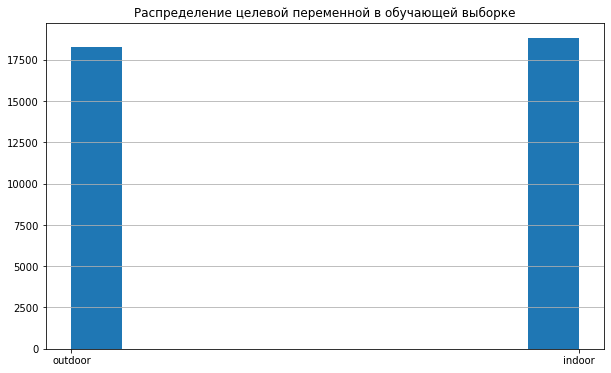

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(y_train)
plt.xticks([0, 1], labels=["outdoor", "indoor"])
plt.grid(axis="y")
plt.title("Распределение целевой переменной в обучающей выборке")
plt.show()

Выборка сбалансирована, переходим к составлению модели **логистической регрессии**

In [7]:
reg = LogisticRegression(random_state=42, solver="liblinear").fit(X_train, y_train)
print(
    "accuracy train score: {:.6f}".format(accuracy_score(y_train, reg.predict(X_train))),
    "accuracy test score: {:.6f}".format(accuracy_score(y_test, reg.predict(X_test))),
    sep="\n"
)

accuracy train score: 0.787023
accuracy test score: 0.788191


Метрика на обучающей и на тестовой выборке практически совпадает, переобучения нет, результат достаточно хороший. Для сравнения попробуем метрические методы и метод опорных векторов. Метод **$K$ ближайших соседей**

In [8]:
%%time

knn = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={"n_neighbors": np.arange(3, 26, 2), "p": [1, 2]},
    cv=KFold(n_splits=5, shuffle=True, random_state=239),
    scoring="accuracy"
)

knn.fit(X_train, y_train)

knn_cv_results = pd.DataFrame(knn.cv_results_).sort_values(by=["rank_test_score"])
knn_cv_results[["param_n_neighbors", "param_p", "mean_fit_time", "mean_test_score", "std_test_score"]].head()

Wall time: 1min 42s


,param_n_neighbors,param_p,mean_fit_time,mean_test_score,std_test_score
23,25,2,0.073517,0.800513,0.002268
21,23,2,0.070515,0.800432,0.002936
20,23,1,0.071462,0.800270,0.002181
19,21,2,0.070968,0.800081,0.001873
18,21,1,0.072428,0.799784,0.002298


In [9]:
print(
    "accuracy train score: {:.6f}".format(accuracy_score(y_train, knn.predict(X_train))),
    "accuracy test score: {:.6f}".format(accuracy_score(y_test, knn.predict(X_test))),
    sep="\n"
)

accuracy train score: 0.816808
accuracy test score: 0.799200


Получилось чуть лучше, но не сильно. Попробуем **метод опорных векторов**

1) линейный

In [10]:
%%time

linear_svc = LinearSVC(random_state=468).fit(X_train, y_train)
print(
    "accuracy train score: {:.6f}".format(accuracy_score(y_train, linear_svc.predict(X_train))),
    "accuracy test score: {:.6f}".format(accuracy_score(y_test, linear_svc.predict(X_test))),
    sep="\n"
)

accuracy train score: 0.787104
accuracy test score: 0.790656
Wall time: 672 ms


2) с радиальной базисной функцией Гаусса

In [11]:
%%time

rbf_svc = SVC(kernel="rbf").fit(X_train, y_train)
print(
    "accuracy train score: {:.6f}".format(accuracy_score(y_train, rbf_svc.predict(X_train))),
    "accuracy test score: {:.6f}".format(accuracy_score(y_test, rbf_svc.predict(X_test))),
    sep="\n"
)

accuracy train score: 0.821071
accuracy test score: 0.814208
Wall time: 2min 15s


3) с полиномиальным ядром второй степени

In [12]:
%%time

poly_svc = SVC(kernel="poly", degree=2, coef0=1.0).fit(X_train, y_train)
print(
    "accuracy train score: {:.6f}".format(accuracy_score(y_train, poly_svc.predict(X_train))),
    "accuracy test score: {:.6f}".format(accuracy_score(y_test, poly_svc.predict(X_test))),
    sep="\n"
)

accuracy train score: 0.815540
accuracy test score: 0.812839
Wall time: 1min 4s


Итог: классическими моделями по квартилям удалось выжать максимум 81% `accuracy`, 